# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW2.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [ ]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn import Conv2d, MaxPool2d, Linear, BatchNorm2d

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH (height of kernel - not input) and width WW (same as height).

        Parameters:
        - w: Filter (kernel) weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


        self.in_channels = in_channels
        self.out_channels = out_channels
  
        if type(kernel_size) == int:
          self.kernel_size = (kernel_size, kernel_size)
        else:
          self.kernel_size = kernel_size

        if type(stride) == int:
          self.stride = (stride, stride)
        else:
          self.stride = stride

        if type(padding) == int:
          self.padding = (padding, padding)
        else:
          self.padding = padding
        
        #initialize the weights
        weights_size = (self.out_channels, self.in_channels, 
                        self.kernel_size[0], self.kernel_size[1])
        self.w = torch.rand(weights_size, requires_grad = True)

        #at first I initialize them with kaimin - but since I wasn't sure if 
        #could use nn.init.kaiming, I changed it to torch.rand
        #self.w = torch.zeros(weights_size, requires_grad = True)
        #nn.init.kaiming_normal_(self.w)
       
        if bias:
          self.bias = torch.rand(self.out_channels, requires_grad= True)
        else:
          self.bias = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        batch_size = x.shape[0]
        c_in = x.shape[1]
        h_in = x.shape[2]
        w_in = x.shape[3]

        #get dimensions of output matrix
        h_out = ((h_in + 2*self.padding[0] - self.kernel_size[0])/self.stride[0])+1
        w_out = ((w_in + 2* self.padding[1] - self.kernel_size[1])/self.stride[1]) + 1

        h_out, w_out = int(h_out), int(w_out)
  
        #convolution is equivalent to unfold + matrix multiplication 
        # + fold (or view, or reshape)

        #unfold
        unfold = nn.Unfold(kernel_size = self.kernel_size,stride = self.stride, 
                           padding = self.padding)
        x_unfold = unfold(x).float()

        #kernel's shape have to be compatible with x_unfold dimensions 
        #for matrix multiplication
        kernel = self.w.reshape(self.out_channels, -1)
  
        #matrix multiplication
        out = torch.matmul(kernel, x_unfold)
  
        #reshape out matrix
        out = out.reshape((batch_size, self.out_channels, h_out, w_out))

        #add bias if needed
        if self.bias:
          out += self.bias
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
random_data = torch.rand(1,1,128,128)*255

conv = Conv2d(1,1,(2,2))
conv2 = nn.Conv2d(1,1,(2,2))

a = conv.forward(random_data)
b = conv2.forward(random_data)

#to check that the shapes are the same 
print(a.shape)
print(b.shape)


In [ ]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        if type(kernel_size) == int:
          self.kernel_size = (kernel_size, kernel_size)
        else:
          self.kernel_size = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        batch_size = x.shape[0]
        channels = x.shape[1]
        h_in = x.shape[2]
        w_in = x.shape[3]

        #get dimensions of output matrix
        h_out = h_in/self.kernel_size[0]
        w_out = w_in/self.kernel_size[1]

        h_out, w_out = int(h_out), int(w_out)

        #unfold
        unfold = nn.Unfold(kernel_size = self.kernel_size, stride = self.kernel_size)
        
        x_unfold = unfold(x)
        x_unfold = x_unfold.reshape(batch_size, channels,
                                 self.kernel_size[0]*self.kernel_size[1],
                                 h_out, w_out)
  
        #get max value across rows
        out = x_unfold.max(dim=2).values
        
        #reshape out matrix
        out = out.reshape((batch_size, channels, h_out, w_out))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [ ]:
random_data = torch.rand(1,1,128,128)*255

max = MaxPool2d((5,5))
max2 = nn.MaxPool2d((5,5))

a = max.forward(random_data)
b = max2.forward(random_data)
print(a.shape)
print(b.shape)

In [19]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.in_channels = in_channels
        self.out_channels = out_channels

        #initialize the weights
        weights_size = (self.in_channels, self.out_channels)
        self.w = torch.rand(weights_size, requires_grad = True)

        self.bias = bias
        if self.bias:
          self.b = torch.rand(self.out_channels, requires_grad= True)
        else:
          self.b = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        out = torch.matmul(x, self.w)
        if self.bias:
          out += self.b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [20]:
random_data = torch.rand(1,1,12,128)*255

linear = Linear(128,7)
linear2 = nn.Linear(128,7)

a = linear.forward(random_data)
print(a.shape)
b = linear2.forward(random_data)
print(a.shape)
print(b.shape)

torch.Size([1, 1, 12, 7])
torch.Size([1, 1, 12, 7])
torch.Size([1, 1, 12, 7])


In [5]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones((1,self.num_features,1,1), requires_grad = True)
        self.beta = torch.zeros((1,self.num_features,1,1), requires_grad = True)
        self.running_mean = None
        self.running_var = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #need mean and variance for each mini-batch(N), 
        #and channel (if convolutional layer)

        if self.training:
          #compute statistics on (N, H, W) dimensions (from documentation)
          mean = x.mean(dim=(0,2,3))
          mean = mean.reshape((1,self.num_features,1,1))
          var = x.var(dim=(0,2,3))
          var = var.reshape((1,self.num_features,1,1))

          with torch.no_grad():
            if self.running_mean is None:
              self.running_mean = mean
              self.running_var = var
            else:
              self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum)*mean
              self.running_var = (1 - self.momentum) * self.running_var + (self.momentum)*var
        with torch.no_grad():
          #compute this both when training and when testing
          x = self.gamma *(x-self.running_mean)/(torch.sqrt(self.running_var + self.eps)) + self.beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return x

In [6]:
random_data = torch.rand(1,2,120,128)*255

batch = BatchNorm2d(2)
batch2 = nn.BatchNorm2d(2)

#print(random_data)
a = batch.forward(random_data)
b = batch2.forward(random_data)
print(a.shape)
print(b.shape)

torch.Size([1, 2, 120, 128])
torch.Size([1, 2, 120, 128])


## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

There are different methods that can be used to train such a network with a large number of trainable parameters, and a training set of a large number of data. Some of this methods are GridSearch, random search or bayesian optimization. In grid search you pick some possible values for each of the parameters you want to optimize, and then try out all the possible combinations of these values to see which one gives better results. In random search, you randomly pick combinations of parameters within your configuration space (available combinations of parameters), and see which one gives better results. Both of these methods are computationally expensive, and take a long time to converge. In bayesian optimisation, you also randomly pick the comination of parameters from your configuration space. However, you update the configuration space  based on outcomes of prior combinations. Taking into account results from previous trials makes bayesian optimization significantly more efficient in finding the best set of parameters, which is why I think it's the best strategy.


In [1]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [2]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel), 
                                  nn.ReLU(inplace=True), 
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel)) 
        
        self.shortcut = nn.Sequential() 
        
        #do this when dimensions don't match (slide 6)
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel) ) 
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [3]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
transforms_train = T.Compose([T.RandomCrop(25),T.RandomHorizontalFlip(), T.ToTensor(), 
                        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transforms = T.Compose([T.ToTensor(), 
                        T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
##############################################################
#                       END OF YOUR CODE                     #
##############################################################




Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html).
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [4]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
data_dir = './data'

cifar_train = dset.CIFAR10(data_dir, train = True,transform = transforms_train, download = True)

#creates the batches
loader_train = DataLoader(cifar_train,
                          batch_size=64, sampler = None) 
                          #sampler.SubsetRandomSampler(range(45000)) - for validation

# validation set for hyperparameter tuning. Validation set will have 5,000 samples
'''
cifar10_val = dset.CIFAR10(data_dir, train=True, download=True,
                         transform=transforms)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                         sampler= sampler.SubsetRandomSampler(range(45000, 50000))) 
                    
'''
cifar_test = dset.CIFAR10(data_dir, train = False,transform = transforms, download = True)
loader_test = DataLoader(cifar_test,
                          batch_size=64)


##############################################################
#                       END OF YOUR CODE                     #       
##############################################################



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [5]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
    

print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc*100

        

def train_part(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #check_accuracy(loader_val, model)
                
      
        if scheduler is not None:
          scheduler.step()

    

In [7]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
'''
-1st I added two additional tranforms - RandomCrop and RandomHorizontalFlip. This 
is added in the Transform cell above
-2nd I tested different learning rates (see for loop in step 1 below). The best 
performing learning rate was 0.001
-3rd I tested learning rate decay starting at 0.005 (the one before  0.001 
in the step above), and at 0.001, with different step_sizes and gammas 
(see for loop in step 2 below). The data showed that the best combination was 
gamma = 0.5, and step size = 3
-4th I checked if changing the batch size to 128 made any improvement. It didn't 
-5th I tried adding extra transformations (T.RandomGrayScale(p=0.3)) to the model with 
the parameters found above to see if that further improved the performance. It 
didn't (this might be because with so much aditional data, the model didn't have
enough time to train, or because the transformation itself - grayscale - wasn't 
a smart option)

'''
#step 1
'''
learning_rate = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
for i in range(len(learning_rate)):
  model = ResNet18()
  optimizer = optim.Adam(model.parameters(), lr = learning_rate[i])

  #scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma = 0.3)
  train_part(model, optimizer, epochs = 10)


  # report validation set accuracy
  print('lr is', learning_rate[i])
  check_accuracy(loader_val, model)
'''

#step 2
'''
learning_rate = [0.005, 0.001]
step_size = [2, 3, 4]
gamma = [0.2, 0.3, 0.4, 0.5, 0.6]

data = []
for i in range(len(learning_rate)):
  for j in range(len(step_size)):
    for g in range(len(gamma)):
      model = ResNet18()
      optimizer = optim.Adam(model.parameters(), lr = learning_rate[i])
      scheduler=optim.lr_scheduler.StepLR(optimizer, step_size= step_size[j] , gamma = gamma[g])
      train_part(model, optimizer, epochs = 10)
      #report validation set accuracy
      print('lr is', learning_rate[i])
      print('step_size', step_size[j])
      print('gamma', gamma[g])
      a = check_accuracy(loader_val, model)
      data.append((learning_rate[i], step_size[j], gamma[g], a))
'''

##############################################################
#                       END OF YOUR CODE                     #
##############################################################


# define and train the network
model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma = 0.5)
train_part(model, optimizer, epochs = 10)


# report test set accuracy

check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), 'model.pt')


782
Epoch: 0, Iteration 0, loss = 3.8984
Epoch: 0, Iteration 100, loss = 1.8930
Epoch: 0, Iteration 200, loss = 1.7385
Epoch: 0, Iteration 300, loss = 1.4560
Epoch: 0, Iteration 400, loss = 1.5252
Epoch: 0, Iteration 500, loss = 1.5652
Epoch: 0, Iteration 600, loss = 1.3970
Epoch: 0, Iteration 700, loss = 1.1905
782
Epoch: 1, Iteration 0, loss = 1.1141
Epoch: 1, Iteration 100, loss = 1.0895
Epoch: 1, Iteration 200, loss = 0.8683
Epoch: 1, Iteration 300, loss = 1.1826
Epoch: 1, Iteration 400, loss = 1.0769
Epoch: 1, Iteration 500, loss = 1.2349
Epoch: 1, Iteration 600, loss = 1.1684
Epoch: 1, Iteration 700, loss = 1.0893
782
Epoch: 2, Iteration 0, loss = 0.9127
Epoch: 2, Iteration 100, loss = 0.7961
Epoch: 2, Iteration 200, loss = 0.7852
Epoch: 2, Iteration 300, loss = 1.2015
Epoch: 2, Iteration 400, loss = 0.7609
Epoch: 2, Iteration 500, loss = 1.2118
Epoch: 2, Iteration 600, loss = 0.9717
Epoch: 2, Iteration 700, loss = 0.8509
782
Epoch: 3, Iteration 0, loss = 0.7835
Epoch: 3, Iterati

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**
 
1. Question 1


As expected, low level maps (closer to the input) capture small, detailed features like edges or lines of the input picture. The higher level maps are less interpretable for the human eye, more pixeled, and  capture more high-level features. The deeper layers, abstract the features to get a more general concept that can be used for classification. As the image progresses through the filters, it gets de-noised and keeps the more important parts to be that are needed for classification.

2. Question 2


As it is shown in part 2, the loss of the network decreases as the training progresses, which is a good indicator that the network is learning. 

The acceptable final accuracy of ~87% shows that the network didn't overfit to the training set (if it had, accuracy in the test set would be lower). This was partly thanks to the aditional transformations performed to the inputs (before I added the transformations, the loss was lower than now by epoch 9, however overall accuracy was lower).

The look of the feature maps is consistent with expectations (as explained in the question above - the layers get more abstract as the training progresses). It's also notable that the high level maps have bright areas, showing that the neurons are activated, and the netwrok is working. 

While the performance is not at par with state-of-the-art results, I believe that given the short training time (10 epochs), the results are satisfactory.

3. Question 3


Besides accuracy, other evaluation metrics can be used. The F-score is a popular option, since it combines recall and precision (although, depending on the application you might want to focus more in one or the other.) Another thing to check when analysing the performance of a model is how fast it trains, if it's scalable, and if it generalises well when tested in a different dataset. To check the latter 2, the model built for this coursework could be trained and tested against the CIFAR100 or PASCAL datasets ( changing only the number of possible output classes).


<Figure size 432x288 with 0 Axes>

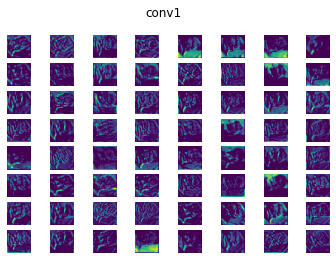

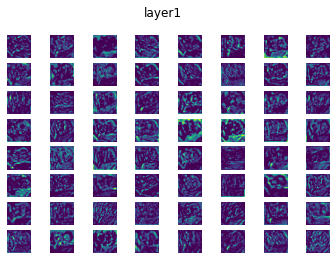

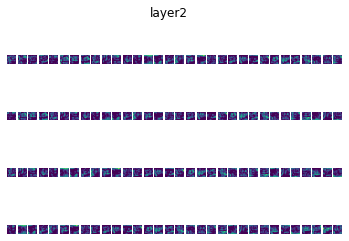

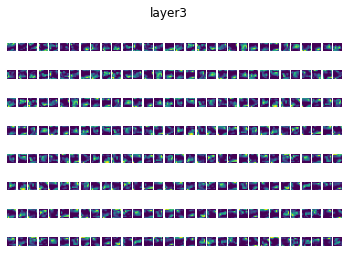

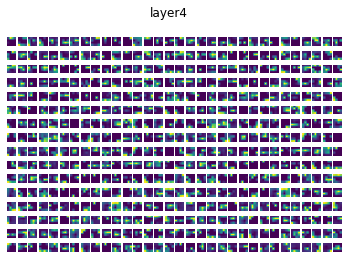

In [ ]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
#data, _ = cifar10_test[0]
data, _ = cifar_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')